In [8]:
import os
import json
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from datascience import *

In [9]:
timestamps_dir = r"/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps"
timestamps = [os.path.join(timestamps_dir, ts) for ts in os.listdir(timestamps_dir)]
timestamps[1]

'/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps/.DS_Store'

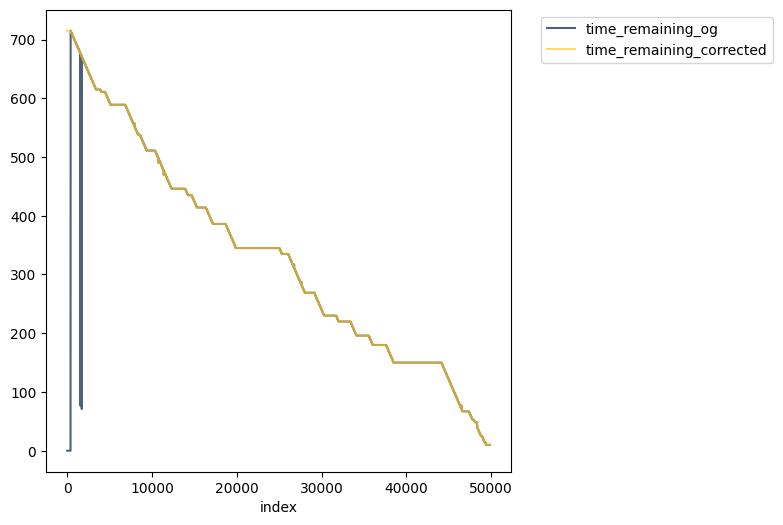

In [14]:
# if a value has a high difference from the moving average, replace it with neighboring value

def moving_average(x, window):
    return np.convolve(x, np.ones(window), 'same') / window

def normalize(arr):
    _min = arr.min()
    _max = arr.max()
    return (arr - _min) / (_max - _min)

def update_time_remaining(remove_indices, time_remaining):
    for idx, remove in enumerate(remove_indices):
        if remove:
            # Find nearest neighbor with remove == 0
            left_idx = idx - 1
            right_idx = idx + 1
            while left_idx >= 0 and remove_indices[left_idx]:
                left_idx -= 1
            while right_idx < len(remove_indices) and remove_indices[right_idx]:
                right_idx += 1
            # Choose the closest valid neighbor
            if left_idx >= 0 and (right_idx >= len(remove_indices) or (idx - left_idx) <= (right_idx - idx)):
                time_remaining[idx] = time_remaining[left_idx]
            elif right_idx < len(remove_indices):
                time_remaining[idx] = time_remaining[right_idx]

i = 3
with open(timestamps[i], 'r') as f:
    data = json.load(f)

time_remaining = []
for k, v in data.items():
    tr = v['time_remaining']
    time_remaining.append(tr) if tr != None else time_remaining.append(0)

time_remaining = np.array(time_remaining)
time_remaining_og = time_remaining.copy()

expected = np.arange(0, 720, 720 / len(time_remaining))[::-1]
diff_expected = abs(expected - time_remaining_og)
norm_expected_diff = normalize(diff_expected)
norm_grad_expected_diff = normalize(np.gradient(diff_expected))
remove_indices = (norm_expected_diff > 0.5).astype(int)

update_time_remaining(remove_indices, time_remaining)

mvg_avg = moving_average(time_remaining, 1000)
diff = abs(time_remaining - mvg_avg)
norm_diff = normalize(diff)
remove_indices = (norm_diff > 0.5).astype(int)

update_time_remaining(remove_indices, time_remaining)

t = Table().with_columns(
    'index', np.arange(0, len(time_remaining)),
    'time_remaining_og', time_remaining_og,
    'time_remaining_corrected', time_remaining,
    # 'expected', expected
)
t.plot('index')

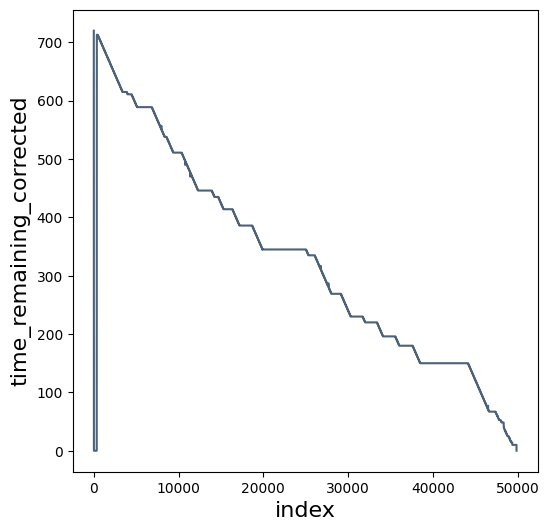

In [149]:
import numpy as np
import json
from datascience import Table

i = 3

# Load data
with open(timestamps[i], 'r') as f:
    data = json.load(f)

time_remaining = []
for k, v in data.items():
    tr = v['time_remaining']
    time_remaining.append(tr) if tr is not None else time_remaining.append(0)

def moving_average(x, window):
    return np.convolve(x, np.ones(window), 'same') / window

time_remaining = np.array(time_remaining)
time_remaining_og = time_remaining.copy()
mvg_avg = moving_average(time_remaining, 500)

diff = abs(time_remaining - mvg_avg)
diff_min = diff.min()
diff_max = diff.max()
norm_diff = (diff - diff_min) / (diff_max - diff_min)
remove_indices = (norm_diff > 0.5).astype(int)

# Correcting values based on the specified conditions
for idx, remove in enumerate(remove_indices):
    if remove:
        # Find nearest neighbor with remove == 0
        left_idx = idx - 1
        right_idx = idx + 1
        while left_idx >= 0 and remove_indices[left_idx]:
            left_idx -= 1
        while right_idx < len(remove_indices) and remove_indices[right_idx]:
            right_idx += 1
        
        # Bias towards higher values for early timestamps
        if idx < len(time_remaining) / 4:  # Assuming first quarter of the game
            if left_idx >= 0 and right_idx < len(remove_indices):
                time_remaining[idx] = max(time_remaining[left_idx], time_remaining[right_idx])
            elif left_idx >= 0:
                time_remaining[idx] = time_remaining[left_idx]
            elif right_idx < len(remove_indices):
                time_remaining[idx] = time_remaining[right_idx]
        else:
            # Use nearest valid value
            if left_idx >= 0 and (right_idx >= len(remove_indices) or (idx - left_idx) <= (right_idx - idx)):
                time_remaining[idx] = time_remaining[left_idx]
            elif right_idx < len(remove_indices):
                time_remaining[idx] = time_remaining[right_idx]

# Enforcing start and end conditions
time_remaining[0] = max(time_remaining[0], 720)
time_remaining[-1] = min(time_remaining[-1], 0)

# Update table and plot
t = Table().with_columns(
    'index', np.arange(0, len(mvg_avg)),
    # 'time_remaining_og', time_remaining_og,
    'time_remaining_corrected', time_remaining
)
t.plot('index')


In [159]:
def post_process_timestamps(time_remaining):

    time_remaining = time_remaining.copy()
    fps = 30
    multiplier = 0
    decreasing = False
    last_index = len(time_remaining)
    for i in range(last_index):
        curr = time_remaining[i]
        peak_value = time_remaining[i]
        if curr == 0:
            continue
        if decreasing:
            if multiplier == 30:
                multiplier = 0
                decreasing = False
            else:
                time_remaining[i] -= round(((1/30) * multiplier), 2)
                multiplier += 1
                continue
        if i < (last_index - fps):
            peak_value = time_remaining[i + fps]
        if peak_value < curr:
            decreasing = True
        else:
            decreasing = False
        if not decreasing:
            time_remaining[i] = 0

    return time_remaining

In [ ]:
t.plot('index')

In [ ]:
fp = 'processed_vids.txt'
dir_p = '/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamp-visualizations'
with open(fp, 'w') as f:
    vids = os.listdir(dir_p)
    for v in vids:
        f.write(v)
        f.write('\n')

In [ ]:
import os

fp = '/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps'
len(os.listdir(fp))